#  Lectura, Análisis y Filtrado de los Datos

---

In [1]:
# =====================================
# Importación de librerías
# =====================================

import time
import pandas as pd
import matplotlib.pyplot as plt
inicio = time.time()

In [2]:
# =====================================
# Importación de datos
# =====================================

print("Lectura name")
df_name = pd.read_csv('Datos/name.basics.tsv.gz', sep='\t', na_values="\\N", low_memory=False, compression="gzip")
print("Lectura akas")
df_akas = pd.read_csv('Datos/title.akas.tsv.gz', sep='\t', na_values="\\N", low_memory=False, compression="gzip")
print("Lectura basics")
df_basics = pd.read_csv('Datos/title.basics.tsv.gz', sep='\t', na_values="\\N", low_memory=False, compression="gzip")
print("Lectura crew")
df_crew = pd.read_csv('Datos/title.crew.tsv.gz', sep='\t', na_values="\\N", low_memory=False, compression="gzip")
print("Lectura principals")
df_principals = pd.read_csv('Datos/title.principals.tsv.gz', sep='\t', na_values="\\N", low_memory=False, compression="gzip")
print("Lectura ratings")
df_ratings = pd.read_csv('Datos/title.ratings.tsv.gz', sep='\t', na_values="\\N", low_memory=False, compression="gzip")


Lectura name
Lectura basics
Lectura crew
Lectura principals
Lectura ratings
Lectura akas



In [3]:
# =====================================
# Comprobación de columnas
# =====================================

print("Columnas Name:", df_name.columns, "\n")
print("Columnas Akas:", df_akas.columns, "\n")
print("Columnas Basics:", df_basics.columns, "\n")
print("Columnas Crew:", df_crew.columns, "\n")
print("Columnas Principals:", df_principals.columns, "\n")
print("Columnas Ratings:", df_ratings.columns, "\n")

Columnas Name: Index(['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession',
       'knownForTitles'],
      dtype='object') 

Columnas Basics: Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object') 

Columnas Crew: Index(['tconst', 'directors', 'writers'], dtype='object') 

Columnas Principals: Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object') 

Columnas Ratings: Index(['tconst', 'averageRating', 'numVotes'], dtype='object') 

Columnas Akas: Index(['titleId', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'isOriginalTitle'],
      dtype='object') 



In [4]:
# =====================================
# Selección y renombrado de columnas
# =====================================

print("Seleccionando columnas relevantes y renombrando...")

df_ename = df_name[['nconst', 'primaryName']].rename(columns={'nconst': 'nid', 'primaryName': 'Nombre'})
df_eakas = df_akas[['titleId', 'title', 'region', 'language']].rename(columns={'titleId': 'tid', 'title': 'Titulo', 'region': 'Region', 'language': 'Idioma'})
df_ebasics = df_basics[['tconst', 'titleType', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']].rename(
    columns={
        'tconst': 'tid',
        'titleType': 'Tipo',
        'primaryTitle': 'Titulo',
        'startYear': 'Año',
        'runtimeMinutes': 'Duracion',
        'genres': 'Generos'
    }
)
df_ecrew = df_crew[['tconst', 'directors']].rename(columns={'tconst': 'tid', 'directors': 'Directores'})
df_eprincipals = df_principals[['tconst', 'nconst', 'category']].rename(columns={'tconst': 'tid', 'nconst': 'nid', 'category': 'Categoria'})
df_eratings = df_ratings[['tconst', 'averageRating', 'numVotes']].rename(columns={'tconst': 'tid', 'averageRating': 'Puntuacion', 'numVotes': 'Num_Votos'})

Seleccionando columnas relevantes y renombrando...


In [5]:
# =====================================
# Filtrado inicial
# =====================================

print("Filtrando por tipo de título...")
df_ebasics = df_ebasics[df_ebasics["Tipo"].isin(["movie", "tvMovie", "tvSeries", "tvMiniSeries","tvSpecial"])].copy()
df_ebasics = df_ebasics.replace("tvMovie", "movie")

df_eprincipals = df_eprincipals[df_eprincipals["Categoria"].isin(["actor", "actress"])].copy()

Filtrando por tipo de título...


In [6]:
# =====================================
# Conversión de datos numéricos
# =====================================

print("Convirtiendo tipos...")
if "Año" in df_ebasics.columns:
    df_ebasics["Año"] = pd.to_numeric(df_ebasics["Año"], errors="coerce", downcast="integer")
if "Duracion" in df_ebasics.columns:
    df_ebasics["Duracion"] = pd.to_numeric(df_ebasics["Duracion"], errors="coerce", downcast="integer")
if "Puntuacion" in df_ratings.columns:
    df_eratings["Puntuacion"] = pd.to_numeric(df_eratings["Puntuacion"], errors="coerce", downcast="float")
if "Num_Votos" in df_eratings.columns:
    df_eratings["Num_Votos"] = pd.to_numeric(df_eratings["Num_Votos"], errors="coerce", downcast="integer")

Convirtiendo tipos...


#  Creación Base de Datos temporales

---

In [7]:
# =====================================
# Creación bases intermedias (actores / directores)
# =====================================

print("Creación database actores")
df_actores = pd.merge(df_eprincipals, df_ename, on='nid', how='outer')

print("Creación database directores")
df_ecrew['Directores'] = df_ecrew['Directores'].str.split(',')
df_ecrew['Directores'] = df_ecrew['Directores'].apply(lambda x: [i.strip() for i in x] if isinstance(x, list) else x)
df_ecrew_separado = df_ecrew.explode('Directores')

df_directores = pd.merge(df_ecrew_separado, df_ename, left_on='Directores', right_on='nid', how='outer')


print("Creación database actores agrupado")
df_actores_agrupado = (df_actores.groupby(['tid']).agg({'Nombre': lambda x: list(set(x))}))

print("Creación database directores agrupado")
df_directores_agrupado = (df_directores.groupby(['tid']).agg({'Nombre': lambda x: list(set(x))}))

print("Renombrado databases actores y directores agrupado")

df_actores_agrupado = df_actores_agrupado.rename(columns={"Nombre": "Actores"})
df_directores_agrupado = df_directores_agrupado.rename(columns={"Nombre": "Directores"})

Creación database actores
Creación database directores
Creación database actores agrupado
Creación database directores agrupado
Renombrado databases actores y directores agrupado


In [8]:
# =====================================
# Creación bases intermedias (titulos en español)
# =====================================

print("Agrupando idiomas por 'tid' ...")
df_eakas_agrupado = (df_eakas.groupby('tid', as_index=False).agg({'Idioma': lambda x: list(set(x))}))

print("Filtrando títulos con región 'ES' ...")
df_eakas_es = df_eakas[df_eakas['Region'] == 'ES'][['tid', 'Titulo']]

print("Combinando títulos ES con los idiomas agrupados ...")
df_eakas_es_agrupado = pd.merge(df_eakas_es, df_eakas_agrupado, on='tid', how='right')

print("Rellenando títulos sin 'ES' con el título genérico ...")
titulo_generico = df_eakas.groupby('tid')['Titulo'].first()
df_eakas_es_agrupado['Titulo_ES'] = df_eakas_es_agrupado['Titulo'].fillna(df_eakas_es_agrupado['tid'].map(titulo_generico))

Agrupando idiomas por 'tid' ...
Filtrando títulos con región 'ES' ...
Combinando títulos ES con los idiomas agrupados ...
Rellenando títulos sin 'ES' con el título genérico ...


In [9]:
# =====================================
# Construcción progresiva de la base de datos
# =====================================

print("Creación database1 (basics + ratings)")
df_1 = pd.merge(df_ebasics, df_eratings, on='tid', how='left')

print("Creación database2 (actores agrupado + directores agrupado)")
df_2 = pd.merge(df_actores_agrupado, df_directores_agrupado, on='tid', how='left')

print("Creación database final (database1 + database2)")
df_3 = pd.merge(df_1, df_2, on='tid', how='left')

print("Creación database final + título español")
df_inicial = pd.merge(df_3, df_eakas_es_agrupado[['tid','Titulo_ES', 'Idioma']], on="tid", how="left")

df_inicial

Creación database1 (basics + ratings)
Creación database2 (actores agrupado + directores agrupado)
Creación database final (database1 + database2)
Creación database final + título español


,tid,Tipo,Titulo,Año,Duracion,Generos,Puntuacion,Num_Votos,Actores,Directores,Titulo_ES,Idioma
0,tt0000009,movie,Miss Jerry,1894.0,45.0,Romance,5.2,231.0,"[Chauncey Depew, Blanche Bayliss, William Cour...",[Alexander Black],Miss Jerry,[nan]
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897.0,100.0,"Documentary,News,Sport",5.3,578.0,NaN,NaN,The Corbett-Fitzsimmons Fight,[nan]
2,tt0000335,movie,Soldiers of the Cross,1900.0,40.0,"Biography,Drama",5.5,64.0,"[Reg Perry, Mr. Graham, Harold Graham, Beatric...","[Herbert Booth, Joseph Perry]",Soldiers of the Cross,[nan]
3,tt0000502,movie,Bohemios,1905.0,100.0,NaN,3.1,25.0,"[El Mochuelo, Antonio del Pozo]",[Ricardo de Baños],Bohemios,[nan]
4,tt0000574,movie,The Story of the Kelly Gang,1906.0,70.0,"Action,Adventure,Biography",6.0,1039.0,"[Godfrey Cass, Bella Cola, Will Coyne, Norman ...",[Charles Tait],The Story of the Kelly Gang,"[nan, en]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1315513,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,2007.0,100.0,Documentary,NaN,NaN,NaN,NaN,De la ilusión al desconcierto: cine colombiano...,[nan]
1315514,tt9916692,movie,Czlowiek bez twarzy,2015.0,66.0,Drama,NaN,NaN,"[Przemyslaw Wasilkowski, Sambor Czarnota, Seba...",[Andrzej Bartnikowski],Czlowiek bez twarzy,[nan]
1315515,tt9916706,movie,Dankyavar Danka,2013.0,NaN,Comedy,7.7,9.0,"[Anvay Bendre, Vijay Patkar, Ashwini Ekbote, P...",[Kanchan Nayak],Dankyavar Danka,"[nan, en]"
1315516,tt9916730,movie,6 Gunn,2017.0,116.0,Drama,7.0,13.0,"[Devadhar Archit, Sunil Barve, Aarti Solanki, ...",[Kiran Gawade],6 Gunn,"[hi, nan]"


#  Guardado Base de Datos Final

---

In [21]:
# =====================================
# Filtrado y comprobación final
# =====================================

df_final = df_inicial[['tid', 'Tipo', 'Titulo', 'Titulo_ES', 'Año', 'Duracion', 'Generos', 'Puntuacion', 'Num_Votos', 'Actores', 'Directores', 'Idioma']].dropna().copy()

if "Año" in df_final.columns:
    df_final["Año"] = pd.to_numeric(df_final["Año"], errors="coerce", downcast="integer")
if "Duracion" in df_final.columns:
    df_final["Duracion"] = pd.to_numeric(df_final["Duracion"], errors="coerce", downcast="integer")
if "Puntuacion" in df_final.columns:
    df_final["Puntuacion"] = pd.to_numeric(df_final["Puntuacion"], errors="coerce", downcast="float")
if "Num_Votos" in df_final.columns:
    df_final["Num_Votos"] = pd.to_numeric(df_final["Num_Votos"], errors="coerce", downcast="integer")

df_final

,tid,Tipo,Titulo,Titulo_ES,Año,Duracion,Generos,Puntuacion,Num_Votos,Actores,Directores,Idioma
0,tt0000009,movie,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,231,"[Chauncey Depew, Blanche Bayliss, William Cour...",[Alexander Black],[nan]
2,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,1900,40,"Biography,Drama",5.5,64,"[Reg Perry, Mr. Graham, Harold Graham, Beatric...","[Herbert Booth, Joseph Perry]",[nan]
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,1039,"[Godfrey Cass, Bella Cola, Will Coyne, Norman ...",[Charles Tait],"[nan, en]"
5,tt0000591,movie,The Prodigal Son,L'enfant prodigue,1907,90,Drama,4.8,36,"[Georges Wague, Christiane Mandelys, Henri Gou...",[Michel Carré],[nan]
9,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120,"Adventure,Fantasy",5.1,81,"[Sam 'Smiling' Jones, Will Morrison, Joseph Sc...","[Otis Turner, Francis Boggs]",[nan]
...,...,...,...,...,...,...,...,...,...,...,...,...
1315502,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,2020,84,Thriller,5.8,1530,"[Anna Foglietta, Sergio Castellitto, Gianluca ...",[Giacomo Cimini],[nan]
1315503,tt9916362,movie,Coven,Akelarre,2020,92,"Drama,History,Horror",6.4,6167,"[Elena Uriz, Irati Saez de Urabain, Lorea Ibar...",[Pablo Agüero],"[tr, cmn, ja, fr, eu, nan, en]"
1315504,tt9916362,movie,Coven,Akelarre,2020,92,"Drama,History,Horror",6.4,6167,"[Elena Uriz, Irati Saez de Urabain, Lorea Ibar...",[Pablo Agüero],"[tr, cmn, ja, fr, eu, nan, en]"
1315508,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123,Drama,7.6,12,"[Marwoto, Cut Mini Theo, Yati Pesek, Ria Irawa...",[Azhar Kinoi Lubis],[nan]


In [22]:
# =====================================
# Guardado de la base de datos final
# =====================================

df_final = df_final[(df_final["Num_Votos"] >= 100)]

df_final.to_csv('Puntuaciones/DatosPeliculasSeries.csv', index=False)

df_final

,tid,Tipo,Titulo,Titulo_ES,Año,Duracion,Generos,Puntuacion,Num_Votos,Actores,Directores,Idioma
0,tt0000009,movie,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,231,"[Chauncey Depew, Blanche Bayliss, William Cour...",[Alexander Black],[nan]
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,1039,"[Godfrey Cass, Bella Cola, Will Coyne, Norman ...",[Charles Tait],"[nan, en]"
100,tt0001892,movie,Den sorte drøm,Den sorte drøm,1911,53,Drama,5.9,291,"[Ellen Feldmann, Gunnar Helsengreen, Tronier F...",[Urban Gad],"[nan, sv]"
105,tt0001964,movie,The Traitress,Die Verräterin,1911,48,Drama,5.8,120,"[Asta Nielsen, Max Wilmsen, Albert Paul, Max O...",[Urban Gad],"[nan, sv]"
122,tt0002101,movie,Cleopatra,Cleopatra,1912,100,"Drama,History",5.1,662,"[Miss Robson, Miss Fielding, Harry Knowles, He...",[Charles L. Gaskill],"[nan, en]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1315447,tt9915022,tvSeries,Yarali Kuslar,Yarali Kuslar,2019,90,Drama,5.1,138,"[Emre Mete Sönmez, Cemre Melis Çinar, Utku Cor...","[Ece Tahtalioglu, Filiz Kuka, Yasemin Erkul, C...","[hi, bg, ja, nan, en]"
1315495,tt9916190,movie,Safeguard,Safeguard,2020,95,"Action,Adventure,Thriller",3.6,266,"[Patrick Gallagher, Leo Ashizawa, Andrei Nova,...",[Fraser Precious],[nan]
1315502,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,2020,84,Thriller,5.8,1530,"[Anna Foglietta, Sergio Castellitto, Gianluca ...",[Giacomo Cimini],[nan]
1315503,tt9916362,movie,Coven,Akelarre,2020,92,"Drama,History,Horror",6.4,6167,"[Elena Uriz, Irati Saez de Urabain, Lorea Ibar...",[Pablo Agüero],"[tr, cmn, ja, fr, eu, nan, en]"


In [ ]:
# =====================================
# Tiempo total de ejecución
# =====================================

final = time.time()
print(f"Tiempo total: {(final-inicio)/60} minutos")

#  Análisis de la Base de Datos Final

---

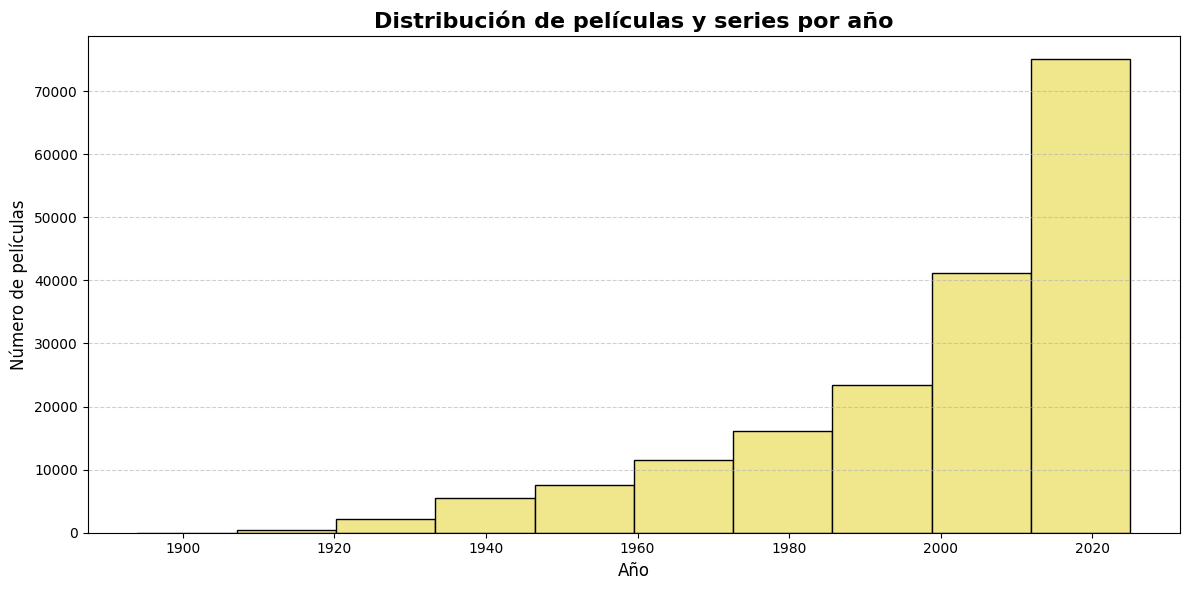

In [23]:
# =====================================
# Distribución de películas por año
# =====================================

plt.figure(figsize=(12, 6))

plt.hist(
    df_final['Año'],
    edgecolor='black',
    color='khaki'
)

plt.title('Distribución de películas y series por año', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de películas', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

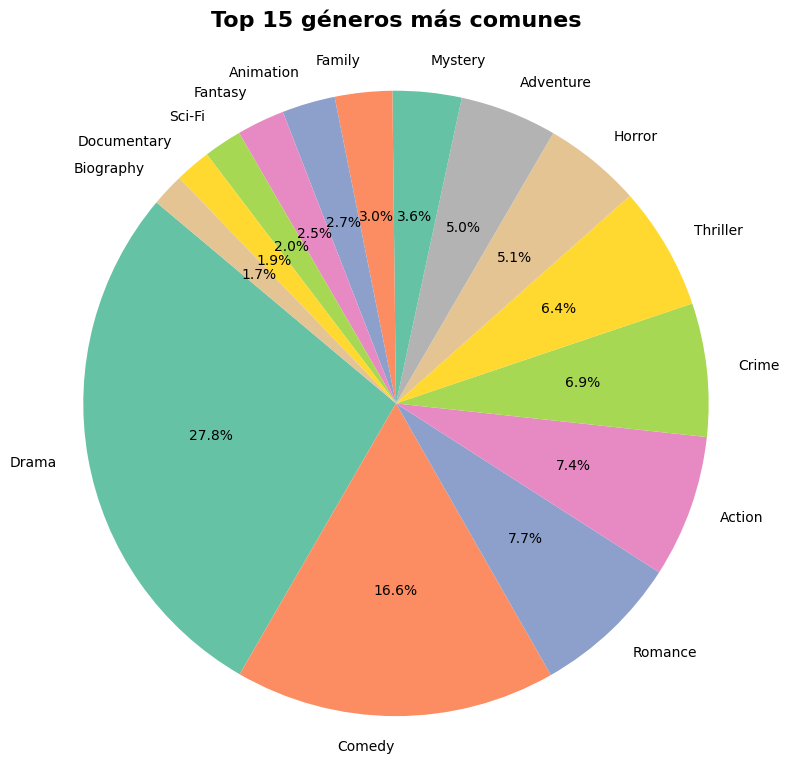

In [39]:
# =====================================================
# Distribución de películas por géneros
# =====================================================

generos_series = (
    df_final['Generos']
    .dropna()
    .str.split(',')
    .explode()
    .str.strip()
)

top_15 = generos_series.value_counts().head(15)

plt.figure(figsize=(8, 8))
plt.pie(
    top_15.values,
    labels=top_15.index,
    autopct='%1.1f%%',
    colors = plt.cm.Set2.colors,
    startangle=140
)

plt.title('Top 15 géneros más comunes', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()

plt.show()


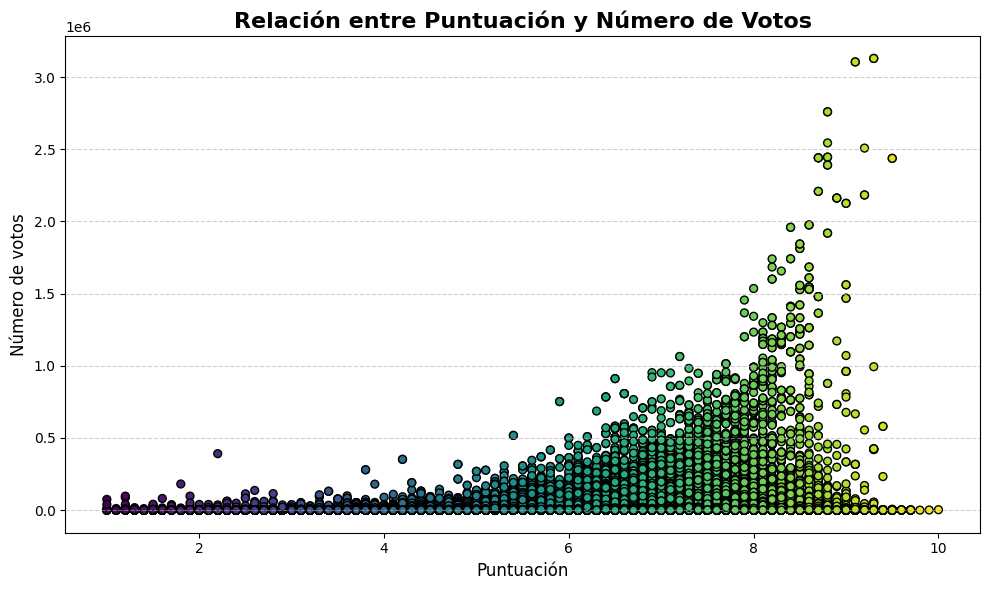

In [40]:
# =====================================
# Puntuación vs Número de votos
# =====================================

plt.figure(figsize=(10, 6))

plt.scatter(
    df_final['Puntuacion'],
    df_final['Num_Votos'],
    s=32,
    c=df_final['Puntuacion'],
    edgecolor='black'
)

plt.title('Relación entre Puntuación y Número de Votos', fontsize=16, fontweight='bold')
plt.xlabel('Puntuación', fontsize=12)
plt.ylabel('Número de votos', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()